In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import profile
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.special import jn

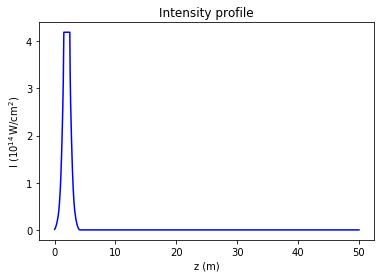

0.0


In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()
print(I[N-1])

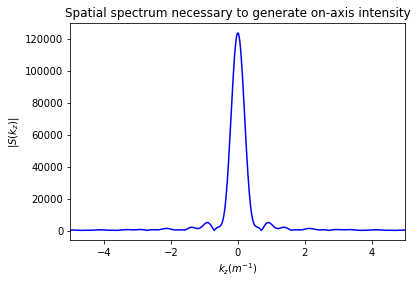

In [3]:
# First what is the spatial spectrum with 0 phase on the entire output
lam = 0.8
k = 2*np.pi/lam

S = fftshift(fft(ionization.field_from_intensity(I)))
kz = fftshift(fftfreq(np.size(z), z[1]-z[0]))
#kr = np.sqrt(k**2 - kz**2)
plt.plot(kz*1e6, abs(S), 'b-')
plt.xlabel(r'$k_z (m^{-1})$')
plt.ylabel(r'$|S(k_z)|$')
plt.title('Spatial spectrum necessary to generate on-axis intensity')
plt.xlim([-5, 5])
plt.show()
# The DC spike is due to the slow asymptotic behavior of adk model
# Requiring ~0 ionization fraction still returns some DC intensity from inverse ADK

k  :  7.853981633974483 um^-1
kz0:  7.85397754329 um^-1
k - kz0:  4.0906813723e-06 um^-1


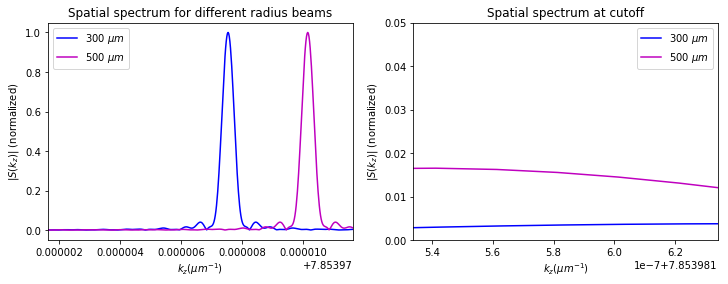

In [4]:
# The distribution is the smae as the unshifted case but centered at kz0
# Rb is the radius of the main lobe of the bessel function
Rb = 0.3e3
kr0 = 2.4048/Rb
kz0 = np.sqrt(k**2-kr0**2)
# The limitation is that our spatial spectrum must fit below k
print('k  : ', k, 'um^-1')
print('kz0: ', kz0, 'um^-1')
print('k - kz0: ', k-kz0, 'um^-1')

# Comparison for a 1mm radius beam
Rbmm = 0.5e3
kr0mm = 2.4048/Rbmm
kz0mm = np.sqrt(k**2-kr0mm**2)
# For normalizing
Smax = np.amax(abs(S))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(kz+kz0, abs(S)/Smax, 'b-', kz+kz0mm, abs(S)/Smax, 'm-')
plt.xlabel(r'$k_z (\mu m^{-1})$')
plt.ylabel(r'$|S(k_z)|$ (normalized)')
plt.title('Spatial spectrum for different radius beams')
plt.xlim([k-1e-5, k])
plt.legend([r'300 $\mu m$', r'500 $\mu m$'])

plt.subplot(122)
plt.plot(kz+kz0, abs(S)/Smax, 'b-', kz+kz0mm, abs(S)/Smax, 'm-')
plt.xlabel(r'$k_z (\mu m^{-1})$')
plt.ylabel(r'$|S(k_z)|$ (normalized)')
plt.title('Spatial spectrum at cutoff')
plt.xlim([k-1e-7, k])
plt.ylim([0,0.05])
plt.legend([r'300 $\mu m$', r'500 $\mu m$'])
plt.show()
# A 300um radius beam is on the edge of what is possible
# we might be able to decrease the tails be getting rid of the corners

Spatial spectrum at kr=0:  0.00370985338204


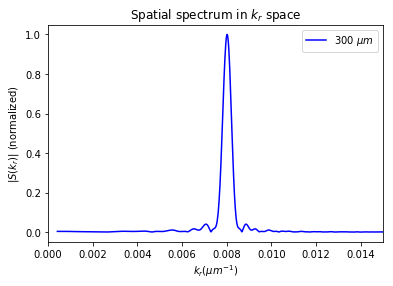

In [5]:
# To take the inverse Henkel transform we need the above in terms of kr
sel = (kz + kz0) <= k
kr = np.sqrt(k**2 - (kz[sel] + kz0)**2)
Sr = S[sel]
print('Spatial spectrum at kr=0: ', abs(Sr[-1])/Smax)

plt.plot(kr, abs(Sr)/Smax, 'b-')
plt.xlabel(r'$k_r (\mu m^{-1})$')
plt.ylabel(r'$|S(k_r)|$ (normalized)')
plt.title(r'Spatial spectrum in $k_r$ space')
plt.xlim([0, .015])
plt.legend([r'300 $\mu m$', r'500 $\mu m$'])
plt.show()

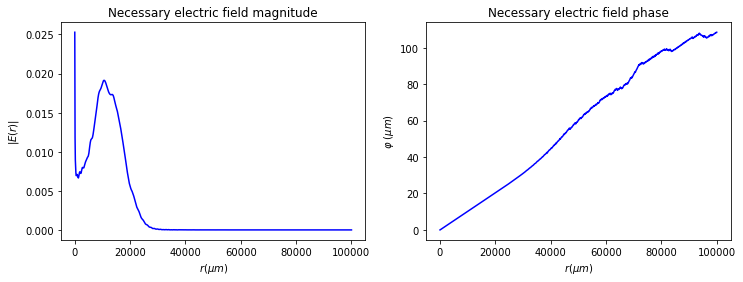

In [6]:
# Now we can take an inverse Hankel transform to find the realspace field
# Most algorithms require r0 = 0 and probably evenly spaced is best
# A nice wide range will give higher resolution,
N = 10000
krn = np.reshape(np.linspace(0, 0.1, N), (1, N))
Srn = interp1d(kr, Sr, fill_value=(Sr[-1], 0.0), bounds_error=False)
Srn = np.reshape(Srn(krn), (1, N))
M = 1000
rm = np.reshape(np.linspace(0, 100e3, M), (M, 1))

#XXX No idea why phi is coming out negative
E = integrate.simps(Srn*jn(0, krn*rm)*krn, krn)
phi = -np.unwrap(np.angle(E))
E = abs(E) * np.exp(-1j*phi)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$')
plt.title(r'Necessary electric field magnitude')

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

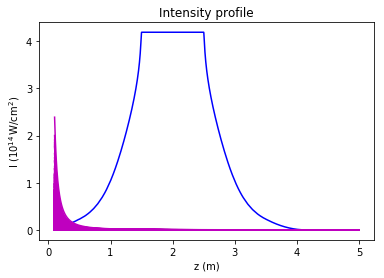

In [7]:
# Test the resulting on axis intensity using the Fresnel diffraction integral
zFres = z[100:5000]
phi = np.unwrap(np.angle(E))
Ea = abs(E)
E = Ea*np.exp(1j*phi)
rm = np.reshape(rm, (1, M))
E = np.reshape(E, (1, M))
e = laser.fresnel_axis(E, rm, zFres, lam)
IFres = ionization.intensity_from_field(abs(e))

plt.plot(zFres/1e6, I[100:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.show()

In [55]:
# The above cell doesn't make any sense, lets try the full propagator
# Initial electric field
rm = np.reshape(rm, (M))
E = np.reshape(E, (M))
Efield = interp1d(rm, E)
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    E0 = Efield(r)
    phi = np.unwrap(np.angle(E0))
    Ea = abs(E0)
    E0 = Ea*np.exp(1j*phi)
    return E0

# Setup the parameters
params = {'Nx' : 2**12,
          'Ny' : 2**9,
          'Nz' : 2**7,
          'Nt' : 2**6,
          'X' : 40e3,
          'Y' : 40e3,
          'Z' : 25e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield
          }

path = '/media/robert/Data_Storage/Data/Optics/Bessel/'

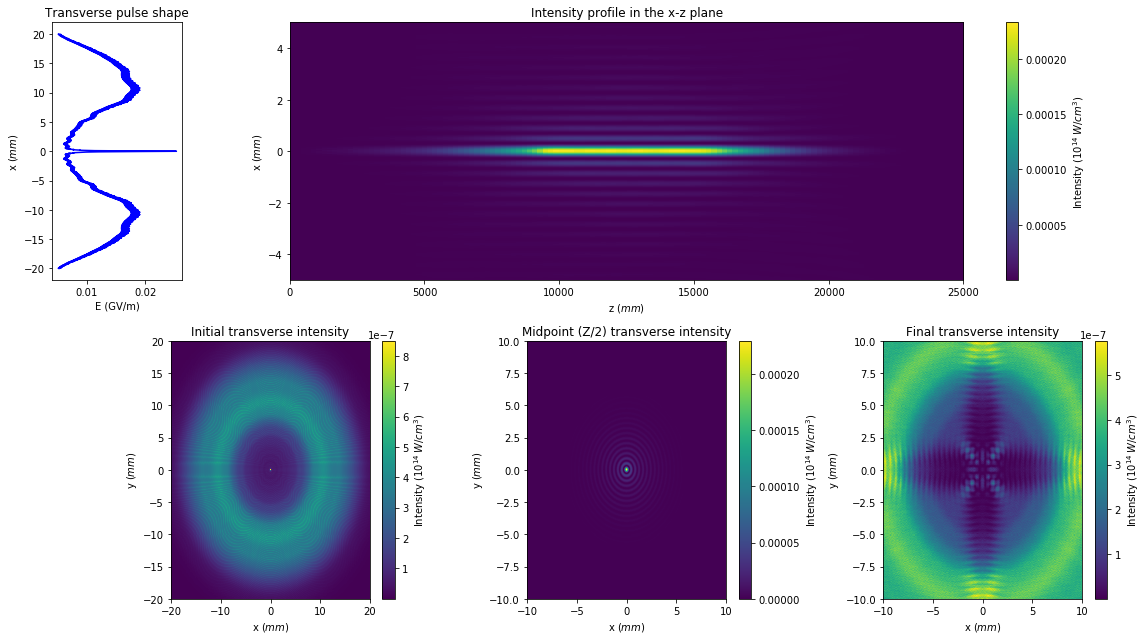

In [56]:
directory = 'Arbitrary_Bessel'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

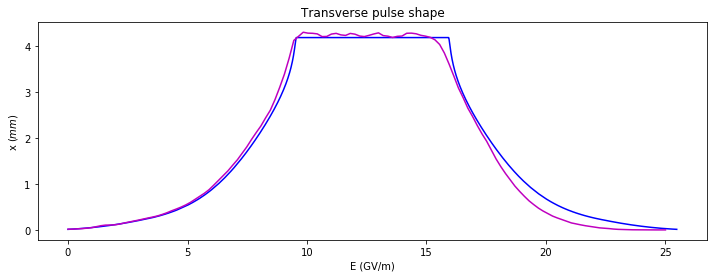

In [59]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))*18500

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1.57e5, I[0:4000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('Transverse pulse shape')
plt.show()